# Featuretools 
Featuretools is a framework to perform automated feature engineering. It excels at transforming temporal and relational datasets into feature matrices for machine learning.

In [1]:
import featuretools as ft

## Loading Raw Data
Loading two separate tables below represented as Pandas dataframes
1. Merge of transactions, sessions, customers
2. List of products

In [2]:
data = ft.demo.load_mock_customer()
transactions_df = data["transactions"].merge(data["sessions"]).merge(data["customers"])
transactions_df.sample(3)

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,date_of_birth
264,380,21,2014-01-01 05:14:10,5,57.09,4,desktop,2014-01-01 05:02:15,60091,2011-04-08 20:08:14,2006-08-15
19,244,10,2014-01-01 02:34:55,2,116.95,2,tablet,2014-01-01 02:31:40,13244,2012-04-15 23:31:04,1986-08-18
314,299,6,2014-01-01 01:32:05,4,64.99,1,tablet,2014-01-01 01:23:25,60091,2011-04-17 10:48:33,1994-07-18


In [3]:
# only 5 unique products in this example
products_df = data["products"]
products_df

,product_id,brand
0,1,B
1,2,B
2,3,B
3,4,B
4,5,A


## Creating an EntitySet
**Naming Conventions**
- **Entity:** Equivalent to a table in relational database. Represented by the Entity class.
- **Instance:** Equivalent to a row in a relational database. Each entity has many instances, and each instance has a value for each variable and feature defined on the entity.
- **Variable:** Equivalent to a column in a relational database. Represented by the Variable class.
- **Feature:** A transformation of data used for machine learning. featuretools has a custom language for defining features as described here. All features are represented by subclasses of FeatureBase.
- **EntitySet:** A collection of entities and the relationships between them. Represented by the EntitySet class.
- **Parent Entity:** An entity that is referenced by another entity via relationship. The "one" in a one-to-many relationship.
- **Target Entity:** The entity on which we will be making a features for.

**Things to Note**<br>
I always need the ability to easily find and differentiate between raw dataframes and entity objects as well as raw columns and derived features
1. There's a clear separation between the raw dataframes I loaded and the explicit entities I define below as part of my EntitySet
2. There's a clear separation between the columns that are loaded as part of the raw dataframes (referred to as "variables" above) and the features I will create later on

### Creating and Adding Individual Entities
**Things to Note**<br>
I always need the ability to do the following w.r.t. creating entities:
1. **Add a friendly name to a given entity**
2. **Add a friendly description to a given entity:** For example, "customer_data" represents a combination of three separate data sources: transactions, sessions, and customers. If I can leave myself a entity description to this effect then I don't have to endure the cognitive burden of keeping track of this info throughout my workflow.
3. **Create an index:** to identify the column that uniquely identifies rows in the entity
4. **Create a time index:** to determine the first and last dated records in any entity
5. **Type-cast columns:** For example, I type cast product_id to categorical below for primitive applicability
6. **View variable vs. feature count:** I want to know how many columns correspond to "variables" vs. "features" given the definitions above

In [4]:
# First, we initialize an empty EntitySet
es = ft.EntitySet(id="customer_data")
es

Entityset: customer_data
  Entities:
  Relationships:
    No relationships

In [5]:
# Next, we add our first individual entity to the entityset
# Great naming conventions here: 'create_entity_from_X'
es = es.entity_from_dataframe(entity_id="transactions", 
                              dataframe=transactions_df,
                              index="transaction_id",
                              time_index="transaction_time",
                              variable_types={"product_id": ft.variable_types.Categorical,
                                              "zip_code": ft.variable_types.ZIPCode})

es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
  Relationships:
    No relationships

In [6]:
# Each column (from raw dataframes) is loaded in as a variable
es["transactions"].variables

[<Variable: transaction_id (dtype = index)>,
 <Variable: session_id (dtype = numeric)>,
 <Variable: transaction_time (dtype: datetime_time_index, format: None)>,
 <Variable: amount (dtype = numeric)>,
 <Variable: customer_id (dtype = numeric)>,
 <Variable: device (dtype = categorical)>,
 <Variable: session_start (dtype: datetime, format: None)>,
 <Variable: join_date (dtype: datetime, format: None)>,
 <Variable: date_of_birth (dtype: datetime, format: None)>,
 <Variable: product_id (dtype = categorical)>,
 <Variable: zip_code (dtype = zip_code)>]

In [7]:
# Next, we add another individual entity
es = es.entity_from_dataframe(entity_id="products",
                              dataframe=products_df,
                              index="product_id")

es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
    products [Rows: 5, Columns: 2]
  Relationships:
    No relationships

**Things to Note**

I have the notion of parent-child entities and separately, parent variables as well as child variables. Explicitly noting certain variables as child variables helps me keep track of the direction of aggregation. Normally, I'd have to explicitly think about these relationships when doing feature engineering work in SQL or Python. Now that I don't have to anymore, help me build trust in the system and interpret it more easily by explicitly calling out relationships that define the direction of aggregation.

In [8]:
# Next we define a parent-child relationship between the transactions and products entities. 
# "Products" is the parent entity and "Transactions" is the child entity (one product to many transactions)
# Note that each ft.Relatioship must denote a one-to-many relationship rather than one-to-one or many-to-many
new_relationship = ft.Relationship(es["products"]["product_id"],
                                   es["transactions"]["product_id"])

es = es.add_relationship(new_relationship)

es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
    products [Rows: 5, Columns: 2]
  Relationships:
    transactions.product_id -> products.product_id

### Normalize Entities
Allows me to create entities from existing tables to reduce the amount of redundant information. We can normalize sessions and customers from the original transactions_df, which has the entity_id "transactions"

In [9]:
es = es.normalize_entity(base_entity_id="transactions",
                         new_entity_id="sessions",
                         index="session_id",
                         make_time_index="session_start",
                         additional_variables=["device", "customer_id", "zip_code", "session_start", "join_date"])

es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 6]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 6]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id

In [11]:
es = es.normalize_entity(base_entity_id="sessions",
                         new_entity_id="customers",
                         index="customer_id",
                         make_time_index="join_date",
                         additional_variables=["zip_code", "join_date"])

es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 6]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 4]
    customers [Rows: 5, Columns: 3]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customers.customer_id

### Visualize EntitySets

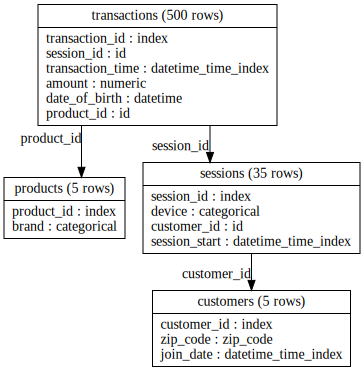

In [12]:
es.plot()

## Use the EntitySet for Feature Generation
**Major Limitation:** DFS is not capable of creating aggregation features with fewer than 2 entities. Featuretools looks for a relationship, and aggregates based on that relationship.

In [15]:
# feature generation by product id
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity="products")
feature_matrix

,brand,COUNT(transactions),MAX(transactions.amount),MEAN(transactions.amount),MIN(transactions.amount),MODE(transactions.session_id),NUM_UNIQUE(transactions.session_id),SKEW(transactions.amount),STD(transactions.amount),SUM(transactions.amount),...,NUM_UNIQUE(transactions.DAY(date_of_birth)),NUM_UNIQUE(transactions.DAY(transaction_time)),NUM_UNIQUE(transactions.MONTH(date_of_birth)),NUM_UNIQUE(transactions.MONTH(transaction_time)),NUM_UNIQUE(transactions.WEEKDAY(date_of_birth)),NUM_UNIQUE(transactions.WEEKDAY(transaction_time)),NUM_UNIQUE(transactions.YEAR(date_of_birth)),NUM_UNIQUE(transactions.YEAR(transaction_time)),NUM_UNIQUE(transactions.sessions.customer_id),NUM_UNIQUE(transactions.sessions.device)
product_id,,,,,,,,,,,,,,,,,,,,,
1,B,102,149.56,73.429314,6.84,3,34,0.125525,42.479989,7489.79,...,4,1,3,1,4,1,5,1,5,3
2,B,92,149.95,76.319891,5.73,28,34,0.151934,46.336308,7021.43,...,4,1,3,1,4,1,5,1,5,3
3,B,96,148.31,73.001250,5.89,1,35,0.223938,38.871405,7008.12,...,4,1,3,1,4,1,5,1,5,3
4,B,106,146.46,76.311038,5.81,29,34,-0.132077,42.492501,8088.97,...,4,1,3,1,4,1,5,1,5,3
5,A,104,149.02,76.264904,5.91,4,34,0.098248,42.131902,7931.55,...,4,1,3,1,4,1,5,1,5,3


In [16]:
# feature generation by customer id
# what if I wanted to do this instead by zip code?
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity="customers")
feature_matrix

,zip_code,COUNT(sessions),MODE(sessions.device),NUM_UNIQUE(sessions.device),COUNT(transactions),MAX(transactions.amount),MEAN(transactions.amount),MIN(transactions.amount),MODE(transactions.product_id),NUM_UNIQUE(transactions.product_id),...,SUM(sessions.MAX(transactions.amount)),SUM(sessions.MEAN(transactions.amount)),SUM(sessions.MIN(transactions.amount)),SUM(sessions.NUM_UNIQUE(transactions.product_id)),SUM(sessions.SKEW(transactions.amount)),SUM(sessions.STD(transactions.amount)),MODE(transactions.sessions.customer_id),MODE(transactions.sessions.device),NUM_UNIQUE(transactions.sessions.customer_id),NUM_UNIQUE(transactions.sessions.device)
customer_id,,,,,,,,,,,,,,,,,,,,,
5,60091,6,mobile,3,79,149.02,80.375443,7.55,5,5,...,839.76,472.231119,86.49,30,0.014384,259.873954,5,mobile,1,3
4,60091,8,mobile,3,109,149.95,80.070459,5.73,2,5,...,1157.99,649.657515,131.51,37,0.002764,356.125829,4,mobile,1,3
1,60091,8,mobile,3,126,139.43,71.631905,5.81,4,5,...,1057.97,582.193117,78.59,40,-0.476122,312.745952,1,mobile,1,3
3,13244,6,desktop,3,93,149.15,67.060430,5.89,1,5,...,847.63,405.237462,66.21,29,2.286086,257.299895,3,desktop,1,3
2,13244,7,desktop,3,93,146.81,77.422366,8.73,4,5,...,931.63,548.905851,154.60,35,-0.277640,258.700528,2,desktop,1,3


In [23]:
# basic sequence analysis
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="sessions",
                                      agg_primitives=["mean", "sum"],
                                      trans_primitives=["time_since_previous"],
                                      ignore_variables={'customers': ['zip_code', 'join_date']})
feature_defs

[<Feature: device>,
 <Feature: customer_id>,
 <Feature: MEAN(transactions.amount)>,
 <Feature: SUM(transactions.amount)>,
 <Feature: TIME_SINCE_PREVIOUS(session_start)>,
 <Feature: MEAN(transactions.TIME_SINCE_PREVIOUS(transaction_time))>,
 <Feature: SUM(transactions.TIME_SINCE_PREVIOUS(transaction_time))>,
 <Feature: customers.MEAN(transactions.amount)>,
 <Feature: customers.SUM(transactions.amount)>]

In [19]:
ft.list_primitives()

,name,type,dask_compatible,koalas_compatible,description
0,trend,aggregation,False,False,Calculates the trend of a variable over time.
1,avg_time_between,aggregation,False,False,Computes the average number of seconds between...
2,min,aggregation,True,True,"Calculates the smallest value, ignoring `NaN` ..."
3,time_since_last,aggregation,False,False,Calculates the time elapsed since the last dat...
4,mean,aggregation,True,True,Computes the average for a list of values.
...,...,...,...,...,...
74,absolute,transform,True,True,Computes the absolute value of a number.
75,less_than_scalar,transform,True,True,Determines if values are less than a given sca...
76,modulo_numeric,transform,True,True,Element-wise modulo of two lists.
77,latitude,transform,False,False,Returns the first tuple value in a list of Lat...
